# Imports

In [1]:
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('stopwords')



/Users/mo/Desktop/ReadyTensor/Projects/mini-rag/.venv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package stopwords to /Users/mo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Reading data

In [2]:
data = pd.read_csv('../examples/papers.csv')[['paper_name', 'abstract']]
# Sample 100 papers for testing
test_sample = data.sample(100, random_state=42)

data = data.drop(test_sample.index).reset_index(drop=True)

documents = data['abstract'].values.tolist()
test_documents = test_sample['abstract'].values.tolist()

# Define the model and create embeddings using the abstracts of the papers

In [3]:
model = SentenceTransformer('all-MiniLM-L6-v2', device='mps')
embeddings = model.encode(documents, show_progress_bar=True)

Batches: 100%|██████████| 1431/1431 [01:46<00:00, 13.38it/s]


# Reduce the dimensions for visualization

In [4]:
tsne = TSNE(n_components=2, perplexity=30, max_iter=300)
embeddings_reduced_tsne = tsne.fit_transform(embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


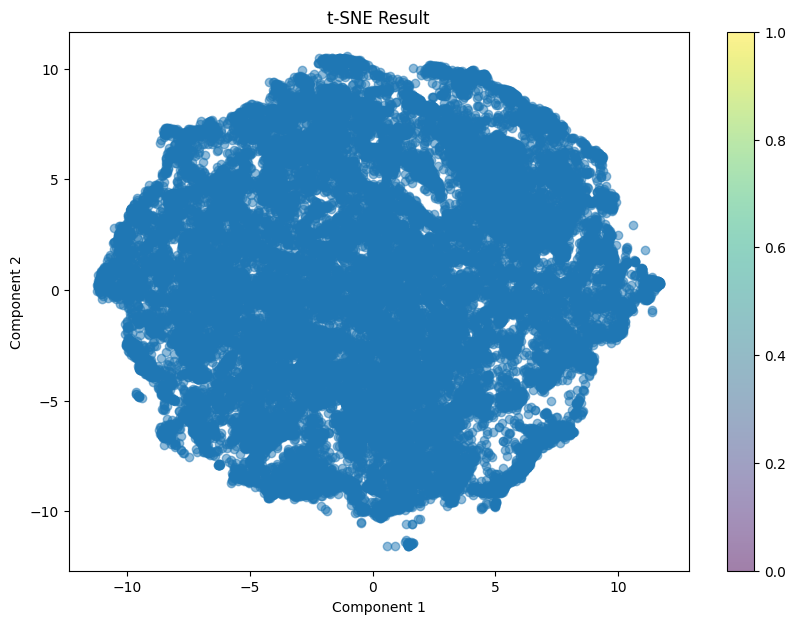

In [5]:
plt.figure(figsize=(10, 7))
plt.scatter(embeddings_reduced_tsne[:, 0], embeddings_reduced_tsne[:, 1], alpha=0.5)
plt.title('t-SNE Result')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar()
plt.show()

# Applying K-Means 

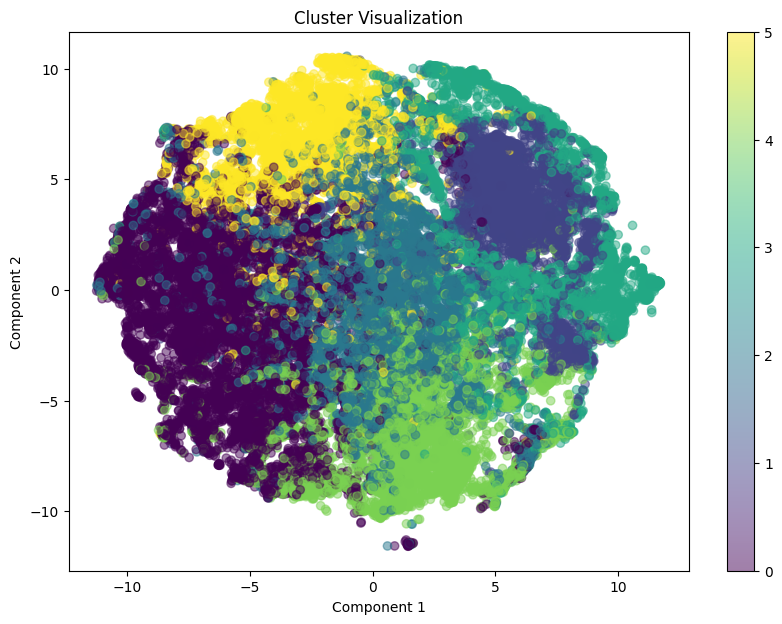

In [6]:
k = 6 
kmeans = KMeans(n_clusters=k, random_state=0)
labels = kmeans.fit_predict(embeddings)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(embeddings_reduced_tsne[:, 0], embeddings_reduced_tsne[:, 1], c=labels, alpha=0.5)
plt.title('Cluster Visualization')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(scatter)
plt.show()

In [7]:
data['kmeans_labels'] = labels

In [8]:
def clean_text(text):
    # Initialize the PorterStemmer
    
    # Remove numbers and punctuation
    text = re.sub(r'\b\d+\b', '', text)  # This regex removes numbers
    text = re.sub(r'[^\w\s]', '', text)  # This regex removes punctuation

    # Convert text to lowercase
    text = text.lower()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]

    # Join words back into a single string
    clean_text = ' '.join(filtered_words)

    return clean_text


cleaned_docs = [clean_text(doc) for doc in documents]

In [9]:
vectorizer = CountVectorizer()
# Fit and transform the documents
X = vectorizer.fit_transform(cleaned_docs)

# Convert to array to make it easier to see what's happening
doc_term_matrix = X.toarray()

# Get feature names to use as column headers
token_names = vectorizer.get_feature_names_out()

# Print the matrix
df = pd.DataFrame(doc_term_matrix, columns=token_names, index=range(len(documents)))
df


,000km,000times,000x,01scd,01x,01x61x,01x77x,02x,03x,04x,...,ﬁxedpoint,ﬁxedtree,ﬂat,ﬂexibility,ﬂexible,ﬂexibly,ﬂoating,ﬂow,𝑡test,𝜸net
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45786,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45787,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45788,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45789,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
def top_n_words(ids, doc_term_matrix, words, n=30):
    top_words = {}
    for i, doc_vector in tqdm(zip(ids, doc_term_matrix), total=len(doc_term_matrix)):
        sorted_word_indexes = np.argsort(doc_vector)[::-1][:n]
        top_words[i] = [(words[idx], doc_vector[idx]) for idx in sorted_word_indexes]
    return top_words

In [11]:
def get_words_of_cluster(data, doc_term_matrix, cluster_label, label_column, n=30):
    cluster_data = data[data[label_column] == cluster_label]
    cluster_doc_term_matrix = doc_term_matrix[cluster_data.index]
    return top_n_words(cluster_data.index, cluster_doc_term_matrix, token_names, n=n)

# Inspect the top 10

100%|██████████| 12824/12824 [00:08<00:00, 1574.65it/s]


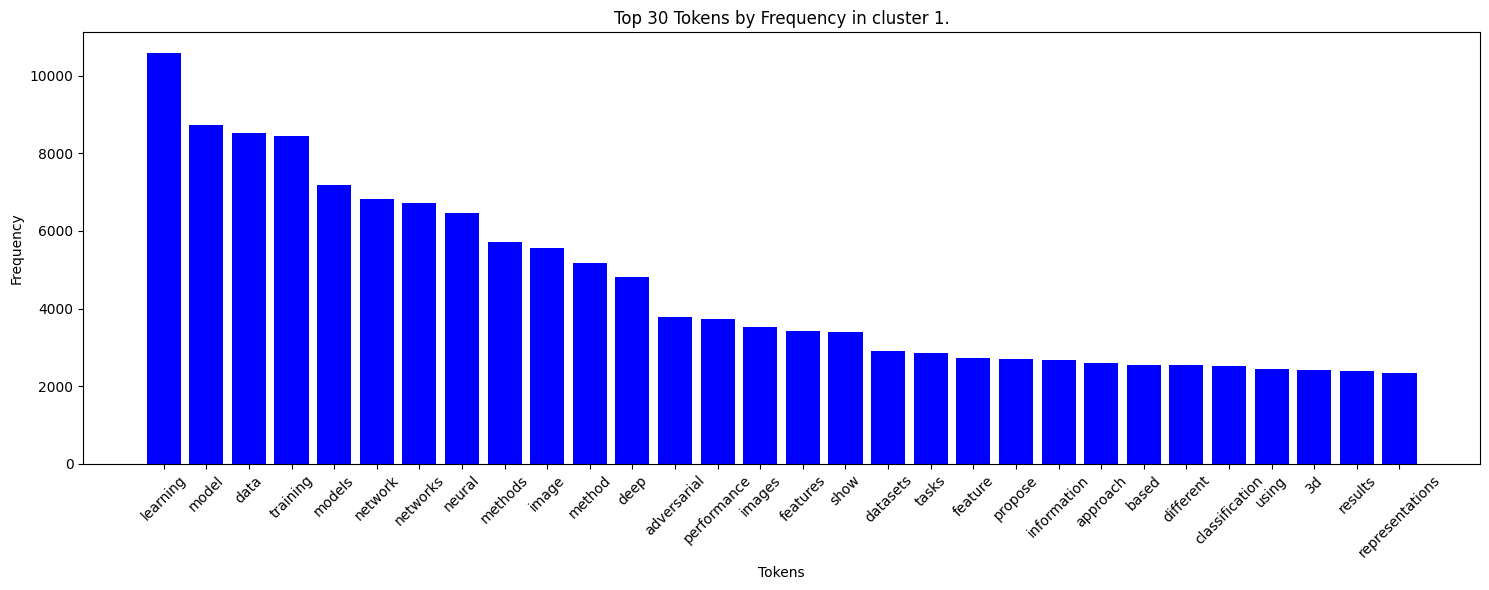

100%|██████████| 6407/6407 [00:03<00:00, 1671.00it/s]


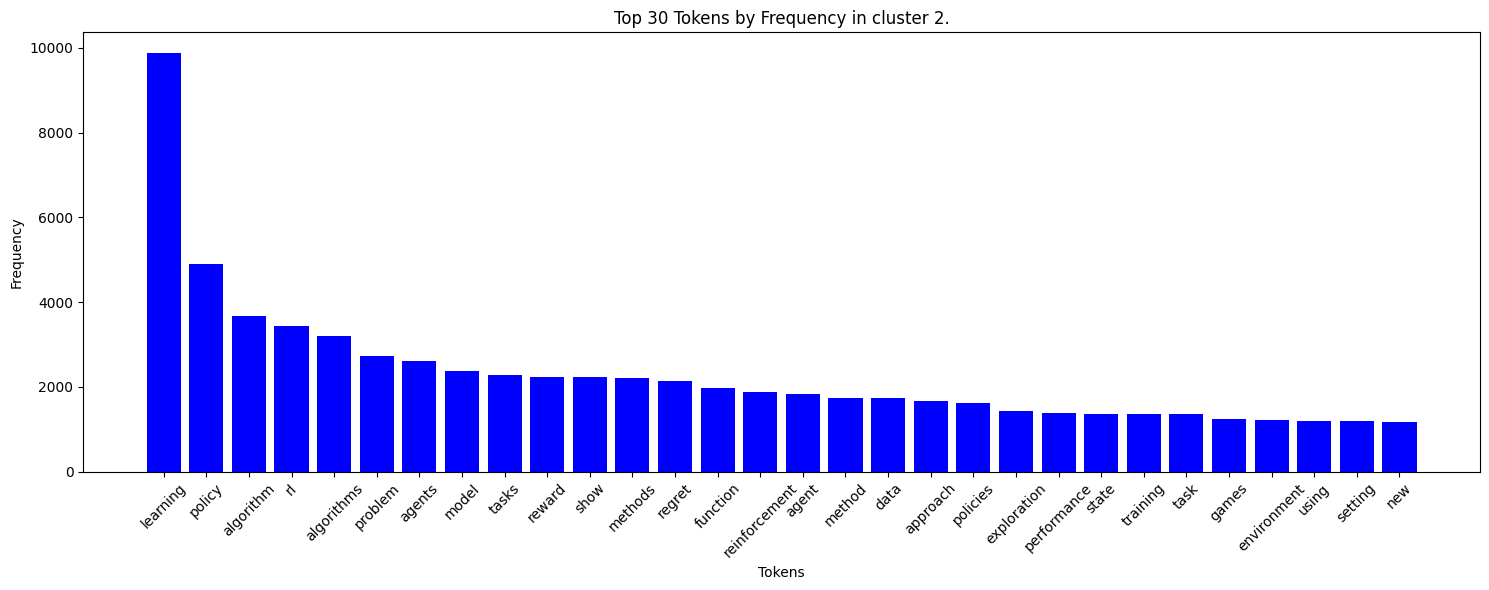

100%|██████████| 8303/8303 [00:05<00:00, 1601.02it/s]


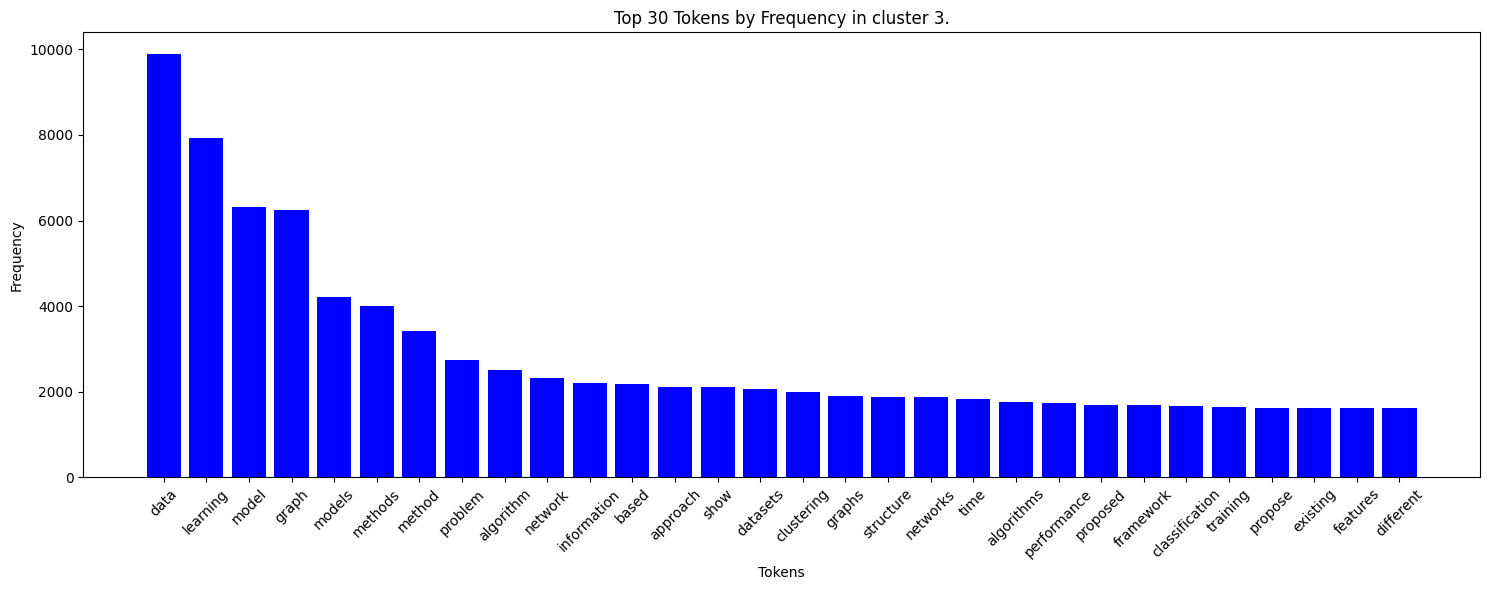

100%|██████████| 5181/5181 [00:02<00:00, 1837.40it/s]


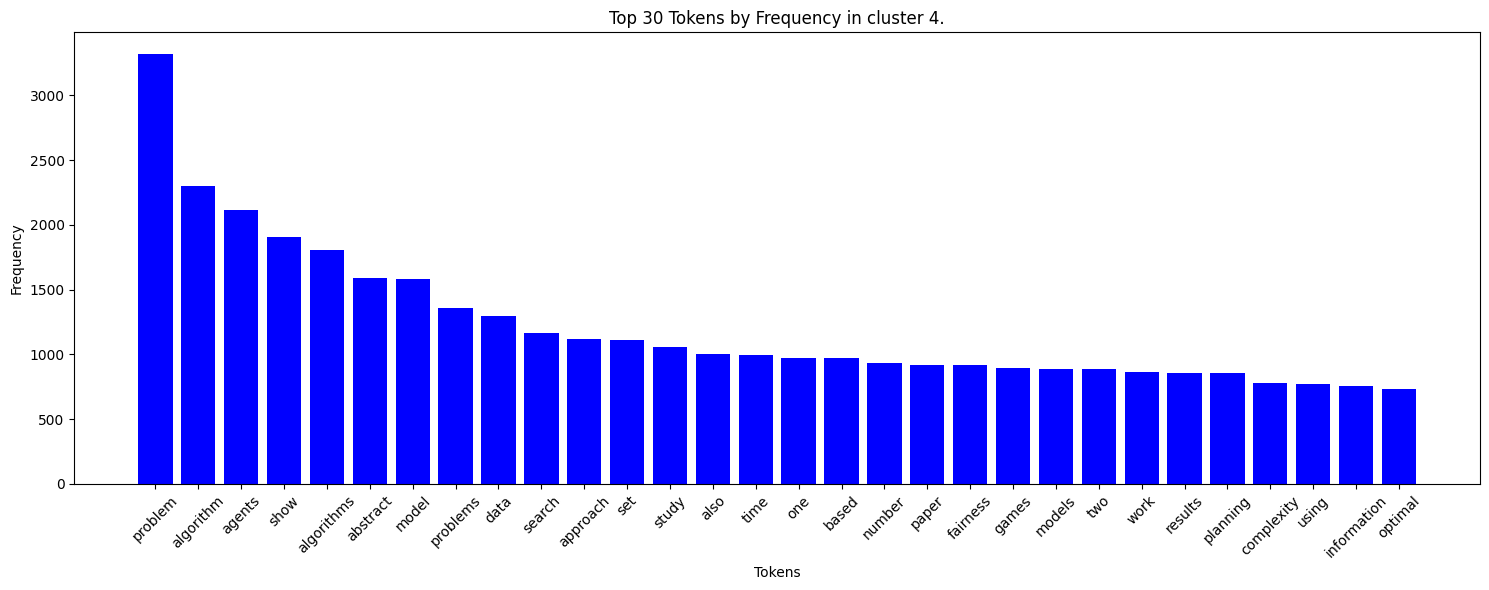

100%|██████████| 7319/7319 [00:04<00:00, 1603.22it/s]


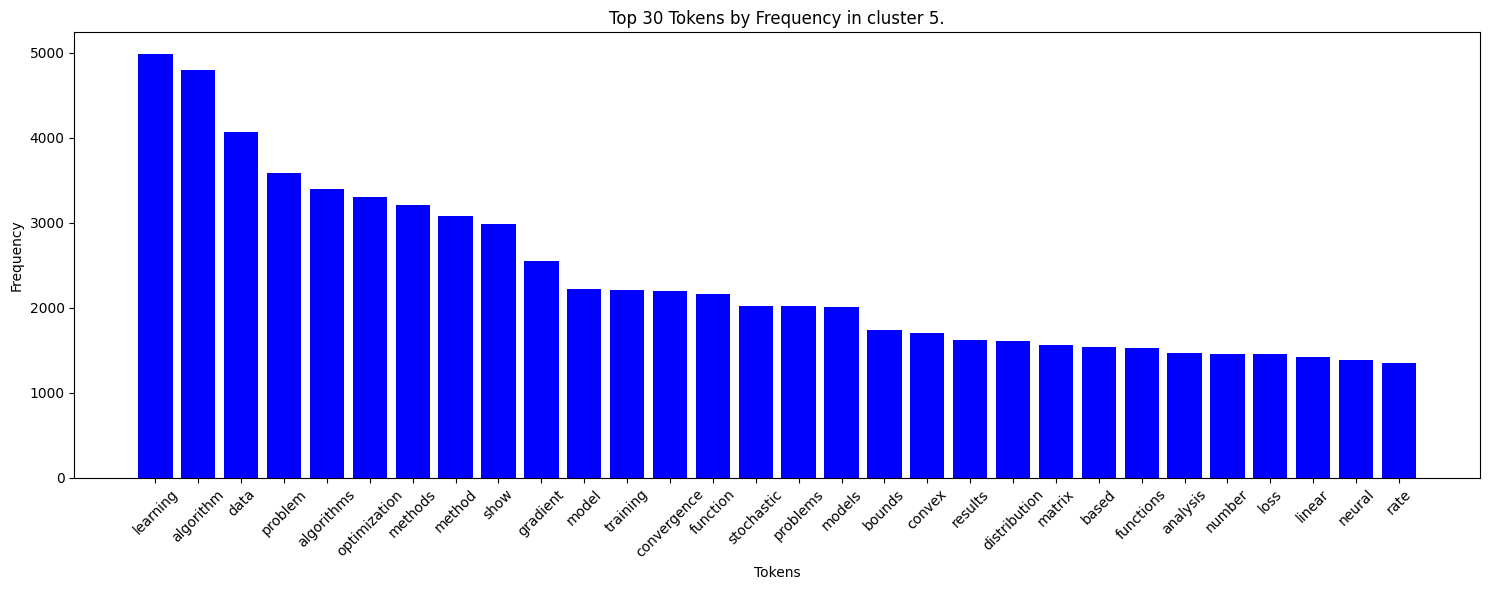

100%|██████████| 5757/5757 [00:03<00:00, 1732.83it/s]


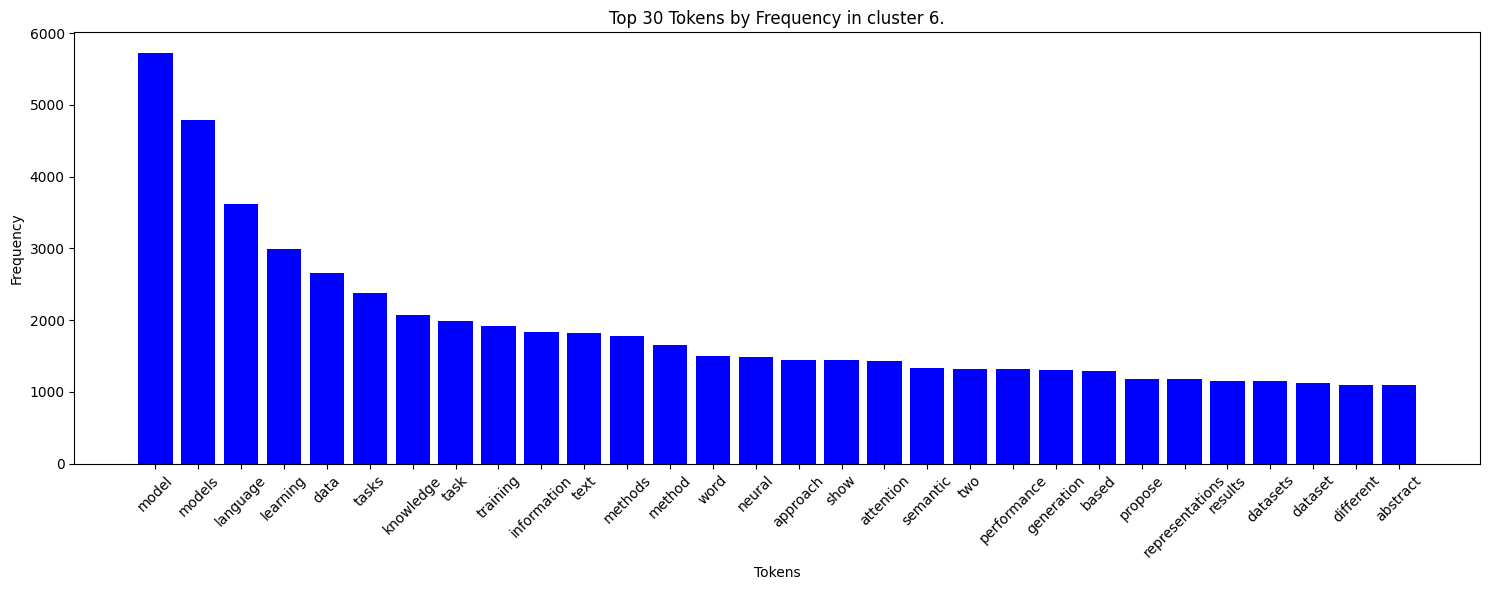

In [16]:
for i in range(k):
    token_counts_per_doc = get_words_of_cluster(data, doc_term_matrix, i, 'kmeans_labels')

    # Using defaultdict to automatically handle missing keys
    token_sums = defaultdict(int)

    # Sum all occurrences for each token
    for token_list in token_counts_per_doc.values():
        for token, count in token_list:
            token_sums[token] += count

    # Convert defaultdict to a regular dict if necessary
    token_sums = dict(token_sums)

    # Sort the dictionary by value and select the top 10
    top_tokens = sorted(token_sums.items(), key=lambda item: item[1], reverse=True)[:30]
    tokens, counts = zip(*top_tokens)  # Unpack the list of tuples into two tuples

    # Creating the bar chart
    plt.figure(figsize=(15, 6))
    plt.bar(tokens, counts, color='blue')

    # Adding titles and labels
    plt.xlabel('Tokens')
    plt.ylabel('Frequency')
    plt.title(f'Top {30} Tokens by Frequency in cluster {i+1}.')
    plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

    # Show the plot
    plt.tight_layout()  # Adjust layout to not cut off labels
    plt.show()


# Generate embeddings for the test documents

In [13]:
test_embeddings = model.encode(test_documents, show_progress_bar=True)

Batches: 100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


# Finding the top 5 similar documents using cosine similarity

In [14]:
n = 5
similarity = cosine_similarity(test_embeddings, embeddings)

# Get the indices of the top n similar embeddings
top_n_indices = similarity.argsort()[:, -n:]


In [15]:
for i, t in enumerate(test_documents[0:3]):
    print(f"Document: {t}")
    print("Most similar documents:")
    for j in range(n):
        idx = top_n_indices[i][j]
        document = documents[idx].replace('\t', ' ')
        print(f"{j}. {document}\n")
    print("---------------------------------\n")


Document: 
    We propose a method for producing ensembles of predictors based on holdout estimations of their generalization performances. This approach uses a prior directly on the performance of predictors taken from a finite set of candidates and attempts to infer which one is best. Using Bayesian inference, we can thus obtain a posterior that represents our uncertainty about that choice and construct a weighted ensemble of predictors accordingly. This approach has the advantage of not requiring that the predictors be probabilistic themselves, can deal with arbitrary measures of performance and does not assume that the data was actually generated from any of the predictors in the ensemble. Since the problem of finding the best (as opposed to the true) predictor among a class is known as agnostic PAC-learning, we refer to our method as agnostic Bayesian learning. We also propose a method to address the case where the performance estimate is obtained from k-fold cross validation. Whi